<a href="https://colab.research.google.com/github/LBainWx/NWS_Projects/blob/master/GetFireEnvironment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython import get_ipython
from IPython.display import display
# %%
# @title Import the Various Libraries
print("Importing various libraries...")
import requests
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from geopy.distance import geodesic
from google.colab import drive

import zipfile
import io
import sys

from datetime import timedelta
import pytz
from geopy.geocoders import Nominatim
from geopy.location import Location


!pip install timezonefinder
from timezonefinder import TimezoneFinder


drive.mount('/content/drive')
print("Finished importing various libraries.")
# %%

Importing various libraries...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 MB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 48.6 MB/s eta 0:00:00


In [ ]:
start_fire_number = 21
radius_miles = 25

In [ ]:
#@title Fetch the Fire Data from Google Drive and Meterological Data
print("Fetching Fire Data from Google Drive...")

#Geometry Data already available so should be able to import it as a gpd
input_fire_df = pd.read_csv('/content/drive/MyDrive/fire/MTR_fires_2014-2024.csv')

#For custom fire input file
#input_fire_df = pd.read_csv('/content/drive/MyDrive/fire/ManualFireDatav1.csv')

# Convert 'geometry' column (assumed to be WKT strings) to shapely objects
from shapely import wkt
input_fire_df['geometry'] = input_fire_df['geometry'].apply(wkt.loads)  # Apply wkt.loads to convert WKT strings to geometry

input_fire_df['DateTime'] = pd.to_datetime(input_fire_df['DateTime'])

def process_duplicates(df):
    # Ensure IncidentSize is numeric
    df['IncidentSize'] = pd.to_numeric(df['IncidentSize'], errors='coerce')

    # Create a copy of the DataFrame to avoid modifying the original
    df_copy = df.copy()

    # Convert 'geometry' column to string representation before grouping
    df_copy['geometry_str'] = df_copy['geometry'].apply(lambda geom: geom.wkt)

    # Group by IncidentName and geometry string, keeping the first record of each
    df_copy = df_copy.groupby(['IncidentName', 'geometry_str'], group_keys=False).first().reset_index()

    # Find the index of the max IncidentSize for each unique name
    idx = df_copy.groupby(['IncidentName'])['IncidentSize'].idxmax()

    # Filter the df to only keep max values
    df_copy = df_copy.loc[idx]

    # Drop the temporary geometry_str column
    df_copy = df_copy.drop('geometry_str', axis=1)

    return df_copy

input_fire_df = process_duplicates(input_fire_df)
#Convert to a GeoDataFrame
fire_ig_df = gpd.GeoDataFrame(input_fire_df,
    geometry='geometry',
    crs="EPSG:4326")

#print(input_fire_df.head())
print("Finished fetching Fire Data from Google Drive")


# --- Fetch Network Data ---
#Network list
network_list = ['1','2','62','229']

#1 = ASOS/AWOS
#2 = RAWS
#62 = DRI
#229 = PGE

networks_string = ','.join(network_list)


# Define the API endpoint for networks
networks_url = "https://api.synopticdata.com/v2/networks"

# Your API token
api_token = 'd8c6aee36a994f90857925cea26934be'

# Parameters for the API request
network_params = {
    'token': api_token,
    'output': 'json'
}

# Make the API request
network_response = requests.get(networks_url, params=network_params)

# Initialize network_dict
network_dict = {}

# Check if the request was successful
if network_response.status_code == 200:
    # Parse the JSON response
    network_data = network_response.json()

    # Extract network information
    networks = network_data.get('MNET', [])

    # Create a dictionary to store network IDs and SHORTNAMEs
    network_dict = {network['ID']: network.get('SHORTNAME', 'Unknown') for network in networks}


# --- End Fetch Network Data ---


# Define radius in miles in which you want to search for RAWS with respect to the fire
#radius_miles = 50
radius_km = radius_miles * 1.60934 # Adjust as needed

#start_fire_number = len(fire_ig_df)-1  # Define the fire number you want to start with



#for fire_number in range(start_fire_number, len(fire_ig_df)): #Iterate through each row of the dataframe
for fire_number in range(start_fire_number, start_fire_number+1): #Iterate through each row of the dataframe
  # Define time buffer in days
  start_buffer_days = 5  # Adjust this as needed
  end_buffer_days = 5  # Adjust this as needed

  cwa = fire_ig_df['WFO'].iloc[fire_number]

  # Assume ignition date is the date in 'DateTime' column
  ignition_date = fire_ig_df['DateTime'].iloc[fire_number].floor('d')

  # Calculate start and end dates for a full calendar day

  start_date = (ignition_date - timedelta(days=start_buffer_days)).strftime('%Y%m%d')
  end_date = (ignition_date + timedelta(days=end_buffer_days)).strftime('%Y%m%d')  # End at midnight of the next day


  cwa_name = cwa
  print(f"Getting data from NWS {cwa_name} CWA, and the data is valid from {start_date}-to-{end_date}")
  #fire_name = (fire_ig_df['Fire Name'].iloc[fire_number] )
  fire_name = (fire_ig_df['IncidentName'].iloc[fire_number] )
  print(f'Fetching surface observations within a {radius_miles} mi radius of the {fire_name} Fire...')


  # Define the URL and parameters from the Synoptic API for station metadata
  metadata_url = "https://api.synopticdata.com/v2/stations/metadata"

  metadata_params = {
      'token': 'd8c6aee36a994f90857925cea26934be',
      'cwa': f'{cwa}',
      'network': networks_string,
      'output': 'json'
  }

  # Make the API request for station metadata
  print(f"Metadata API Request URL: {metadata_url}?{'&'.join([f'{key}={value}' for key, value in metadata_params.items()])}")
  metadata_response = requests.get(metadata_url, params=metadata_params)

  # Check if the metadata request was successful
  if metadata_response.status_code == 200:
      metadata = metadata_response.json()
      stations = metadata.get('STATION', [])

      if not stations:
          print("No stations found for the given parameters and networks in the metadata. Please check parameters and network list.")
          print(f"Parameters used: {metadata_params}")
      else:
          print(f"Found {len(stations)} stations for the given parameters and networks in the metadata")
          # Prepare to store dataframes for each station
          station_dfs = {}

          # Define the URL for the time series API
          timeseries_url = "https://api.synopticdata.com/v2/stations/timeseries"

          # Iterate through each station and get time series data
          for station in stations:
              stid = station.get('STID')
              name = station.get('NAME')
              latitude = station.get('LATITUDE')
              longitude = station.get('LONGITUDE')
              elevation = station.get('ELEVATION')

              # Calculate distance between fire and station
              station_coord = Point(float(longitude), float(latitude))
              distance = fire_ig_df.geometry.iloc[fire_number].distance(station_coord)  # Distance in degrees
              distance_km = distance * 111.32  # Approximate conversion

              # Only proceed if the station is within the radius
              if distance_km > radius_km:
                print(f"Skipping station {stid} - Out of radius")
                continue  # Skip to the next station if it's outside the radius

              # Use MNET_ID directly
              if 'MNET_ID' in station:
                network_id = str(station.get('MNET_ID'))
              else:
                network_id = None

              if network_id is not None:
                if network_id in network_dict:
                    shortname = network_dict[network_id]
                    print(f"STID: {stid}, Network: {shortname}")
                else:
                    print(f"STID: {stid}, Network: Unknown Network (ID {network_id} not found in network dictionary)")
              else:
                  print(f"STID: {stid}, Network: Unknown Network (No MNET_ID)")


              timeseries_params = {
                  'token': 'd8c6aee36a994f90857925cea26934be',
                  'stid': stid,
                  'units': 'english',
                  'start': f'{start_date}0000',
                  'end': f'{end_date}0000'
              }
              #print(f"Timeseries API Request URL: {timeseries_url}?{'&'.join([f'{key}={value}' for key, value in timeseries_params.items()])}")

              timeseries_response = requests.get(timeseries_url, params=timeseries_params)

              #Check for a successful response before parsing JSON
              if timeseries_response.status_code == 200:
                  try:
                      timeseries_data = timeseries_response.json()
                      # Check if 'STATION' key exists and is not empty
                      if timeseries_data.get('STATION') and timeseries_data.get('STATION')[0].get('OBSERVATIONS'):
                          observations = timeseries_data.get('STATION', [{}])[0].get('OBSERVATIONS', {}) #Extract observations
                      else:
                          observations = {}
                          print(f"No timeseries data found for station {stid}.")
                  except requests.exceptions.JSONDecodeError as e:
                      print(f"JSONDecodeError for station {stid}: {e}")
                      continue  # Skip to the next station if JSON is invalid


                  # Convert the observations into a DataFrame
                  if observations: # Check if observations is not empty
                      df = pd.DataFrame(observations)

                      # Check if DataFrame is empty
                      if df.empty:
                          print(f"DataFrame for station {stid} is empty. Skipping.")
                          continue # Skip to the next station in the for loop

                      # Rename the columns
                      rename_dict = {
                          'air_temp_set_1': 'tempf',
                          'dew_point_temperature_set_1d': 'dewptf',
                          'relative_humidity_set_1': 'rh',
                          'wind_speed_set_1': 'wind_speed_mph',
                          'wind_direction_set_1': 'wind_direction_degrees',
                          'wind_gust_set_1': 'peak_wind_gust_mph',
                          'peak_wind_direction_degree': 'peak_wind_direction_degrees',
                          #'peak_wind_speed_set_1': 'sustained_wind_knots',
                          'fuel_moisture_set_1' : 'fuel10_moisture',
                          'fuel_temp_set_1': 'fuel10f',
                          'visibility_set_1': 'visibility',
                          'altimeter_set_1': 'altimeter',
                          'sea_level_pressure_set_1': 'sea_level_pressure',
                          'NETWORK_NAME' : 'network',
                          'precip_accum_set_1' : 'precip_accum',
                          'solar_radiation_set_1' : 'solar_radiation'
                      }

                      # Filter the rename_dict to only include columns present in the DataFrame
                      rename_dict = {k: v for k, v in rename_dict.items() if k in df.columns}

                      df.rename(columns=rename_dict, inplace=True)

                      # List of columns to ensure they are converted to float
                      columns_to_convert = [
                          'tempf',
                          'dewptf',
                          'rh',
                          'wind_speed_mph',
                          'wind_direction_degrees',
                          'peak_wind_gust_mph',
                          'peak_wind_direction_degrees',
                          'fuel10',
                          'visibility',
                          'altimeter',
                          'sea_level_pressure',
                          'precip_accum',
                          'solar_radiation',
                          'network',
                      ]
                      # Convert specified columns to float if they exist in the DataFrame
                      for column in columns_to_convert:
                          if column in df.columns:
                              df[column] = pd.to_numeric(df[column], errors='coerce')

                      # Convert wind-related columns from knots to mph if they exist
                      wind_columns = ['wind_speed_mph', 'peak_wind_gust_mph']
                      for wind_column in wind_columns:
                          if wind_column in df.columns:
                              # Fill NaNs with 0 or another appropriate value if needed
                              df[wind_column] = df[wind_column].fillna(0)
                              # Convert from knots to mph, round, and convert to integer
                              df[wind_column] = (df[wind_column] * 1.15078).astype(float)

                      # Add the station ID, latitude, longitude, and elevation as new columns
                      df['stid'] = stid
                      # Convert latitude and longitude to float here
                      df['latitude'] = float(latitude)
                      df['longitude'] = float(longitude)
                      df['elevation_feet'] = elevation
                      df['name'] = name
                      df['name'] = df['name'].str.title().str.replace('-', ' ')


                      # Convert 'date_time' column to datetime format if it exists
                      if 'date_time' in df.columns:
                        df['DateTime'] = pd.to_datetime(df['date_time'])
                        #del df['date_time'] # Remove the old column

                      if network_id is not None:
                          if network_id in network_dict:
                              df['network'] = network_dict.get(network_id, 'Unknown Network')
                          else:
                              df['network'] = 'Unknown Network'
                      else:
                          df['network'] = 'Unknown Network'
                      # Store the DataFrame in the dictionary with station ID as
                      # the key
                      station_dfs[stid] = df
                  else:
                      print(f"No observations found for station {stid}, skipping dataframe creation")
              else:
                  print(f"Failed to retrieve timeseries data for station {stid}. Status code: {timeseries_response.status_code}")
                  if timeseries_response.status_code != 200:
                      try:
                          print(f"Error Message from API: {timeseries_response.json().get('RESPONSE_MESSAGE')}")
                      except:
                          print("Could not decode JSON error message from API")
                  continue  # Skip to the next station if the request failed


          if station_dfs: # Only continue if station_dfs is not empty
                print("Converting to DataFrame and Saving Data")
                fire_obs = pd.concat(station_dfs.values(), ignore_index=True)

                #Append Fire to things
                fire_ig_df = fire_ig_df.reset_index(drop=True)  # Reset index for fire_ig_df
                #fire_obs['Fire Name'] = fire_ig_df.loc[fire_number, 'Fire Name'] #Need to change Fire Name to Incident Name
                fire_obs['IncidentName'] = fire_ig_df.loc[fire_number, 'IncidentName'] # Append IncidentName using .iloc


                print(f'The number of observations in this dataset is {len(fire_obs)}')

                def calculate_distance(row):
                    """Calculates the distance between a station and the fire location in miles.

                    Args:
                        row: A row of the DataFrame containing station coordinates.

                    Returns:
                        The distance between the station and the fire location in miles.
                    """
                    ###If non-geometry in the dataframe
                    #fire_location = (fire_ig_df['Latitude'].iloc[fire_number], fire_ig_df['Longitude'].iloc[fire_number])  # Get fire location
                    #station_location = (row['LATITUDE'], row['LONGITUDE'])  # Get station location
                    #distance = geodesic(fire_location, station_location).miles  # Calculate distance in miles
                    #return distance

                    # Get fire location from the geometry column
                    fire_location_geom = fire_ig_df['geometry'].iloc[fire_number]
                    fire_location = (fire_location_geom.y, fire_location_geom.x) #Extract lat/lon from geometry object
                    station_location = (row['latitude'], row['longitude'])  # Get station location
                    distance = geodesic(fire_location, station_location).miles  # Calculate distance in miles
                    return distance

                #Calculate distance from the observation to the fire
                fire_obs['distance_to_fire_miles'] = fire_obs.apply(calculate_distance, axis=1)


                #Remove unnecessary columns
                if 'heat_index_set_1d' in fire_obs.columns:
                  del fire_obs['heat_index_set_1d']
                if 'wind_cardinal_direction_set_1d' in fire_obs.columns:
                  del fire_obs['wind_cardinal_direction_set_1d']
                if 'volt_set_1' in fire_obs.columns:
                  del fire_obs['volt_set_1']
                #del fire_obs['peak_wind_set_1']

                # Define the desired order of columns
                desired_order = ['DateTime','IncidentName','stid','name','tempf','rh','dewptf',
                                'wind_speed_mph', 'wind_direction_degrees',
                                'peak_wind_gust_mph','peak_wind_direction_degrees',
                                'fuel10_moisture','fuel10f',
                                'visibility', 'altimeter','sea_level_pressure','precip_accum',
                                'solar_radiation','network','latitude','longitude','elevation_feet', 'distance_to_fire_miles']



                #Filter desired_order to only include columns present in fire_obs
                desired_order = [col for col in desired_order if col in fire_obs.columns]
                fire_obs = fire_obs[desired_order]


                # --- Timezone Conversion Code ---
                def apply_timezone_conversion(df):
                  # Import necessary libraries if they haven't been already
                  import pandas as pd
                  import pytz
                  from timezonefinder import TimezoneFinder

                  def get_timezone_name(tf, latitude, longitude):
                    """
                    Retrieves the time zone name for a given latitude and longitude using timezonefinder.
                    """
                    return tf.timezone_at(lng=longitude, lat=latitude)

                  def convert_to_local_time(utc_datetime, latitude, longitude, tf):
                    """
                    Converts a UTC datetime to local time based on latitude and longitude.
                    """
                    if pd.isnull(utc_datetime) or pd.isnull(latitude) or pd.isnull(longitude):
                        return None

                    timezone_name = get_timezone_name(tf, latitude, longitude)
                    if timezone_name:
                        try:
                            tz = pytz.timezone(timezone_name)
                            utc_datetime = pd.to_datetime(utc_datetime, utc=True)  # Ensure it's in UTC
                            return utc_datetime.tz_convert(tz)  # Convert to local time
                        except pytz.UnknownTimeZoneError:
                            print(f"Unknown time zone: {timezone_name}")
                        except Exception as e:
                            print(f"Error converting time: {e}")
                    return None  # Return None if conversion fails

                  # Apply timezone conversion efficiently
                  tf = TimezoneFinder() #Instantiate TimezoneFinder outside of the loop
                  df['local_time'] = list(map(convert_to_local_time, df['DateTime'], df['latitude'], df['longitude'], [tf]*len(df)))
                  print("Timezone conversion completed. 'local_time' column added.")
                  return df

                fire_obs = apply_timezone_conversion(fire_obs)


                # --- End Timezone Conversion

                #Reorder columns to put local_time after DateTime

                # Add 'local_time' to the desired order right after 'DateTime'
                if 'local_time' in fire_obs.columns:
                  desired_order.insert(desired_order.index('DateTime')+1, 'local_time')


                #Filter desired_order to only include columns present in fire_obs
                desired_order = [col for col in desired_order if col in fire_obs.columns]
                fire_obs = fire_obs[desired_order]


                # Get unique STID and NAME values
                unique_stids_names = fire_obs[['stid', 'name', 'distance_to_fire_miles', 'network']].drop_duplicates()

                # Display the result
                print(f'The name of observation(s) used that are within {radius_miles} mi of the {fire_name} incident are:')
                print(unique_stids_names.sort_values(by='distance_to_fire_miles', ascending=False))

                output_dir = '/content/drive/MyDrive/fire/OutputFiles/text/fireobs/'
                #fire_obs.to_csv(f'{output_dir}{fire_name}-{radius_miles}mi-radius-{cwa}.csv', index=False)
                print(f'Surface data within {radius_miles} mi of the {fire_name} Fire has been saved')

                #print("Network Dictionary:", network_dict)

          else:
              print("No stations within the radius after filtering, skipping concatenation.")
  else:
      print(f"Failed to retrieve station metadata. Status code: {metadata_response.status_code}")
      if metadata_response.status_code != 200:
          try:
              print(f"Error Message from API: {metadata_response.json().get('RESPONSE_MESSAGE')}")

          except:
               print("Could not decode JSON error message from API")
# %%
fire_obs.head(25)
# %%
fire_obs
# %%
import pandas as pd
import pytz
from timezonefinder import TimezoneFinder

def get_timezone_name(tf, latitude, longitude):
    """
    Retrieves the time zone name for a given latitude and longitude using timezonefinder.
    """
    return tf.timezone_at(lng=longitude, lat=latitude)

def convert_to_local_time(utc_datetime, latitude, longitude, tf):
    """
    Converts a UTC datetime to local time based on latitude and longitude.
    """
    if pd.isnull(utc_datetime) or pd.isnull(latitude) or pd.isnull(longitude):
        return None

    timezone_name = get_timezone_name(tf, latitude, longitude)
    if timezone_name:
        try:
            tz = pytz.timezone(timezone_name)
            utc_datetime = pd.to_datetime(utc_datetime, utc=True)  # Ensure it's in UTC
            return utc_datetime.tz_convert(tz)  # Convert to local time
        except pytz.UnknownTimeZoneError:
            print(f"Unknown time zone: {timezone_name}")
        except Exception as e:
            print(f"Error converting time: {e}")
    return None  # Return None if conversion fails

# Apply timezone conversion efficiently
if 'fire_obs' in locals() and isinstance(fire_obs, pd.DataFrame) and not fire_obs.empty:
    tf = TimezoneFinder() #Instantiate TimezoneFinder outside of the loop
    fire_obs['local_time'] = list(map(convert_to_local_time, fire_obs['DateTime'], fire_obs['latitude'], fire_obs['longitude'], [tf]*len(fire_obs)))
    print("Timezone conversion completed. 'local_time' column added.")
else:
    print("fire_obs dataframe not found or is empty.")

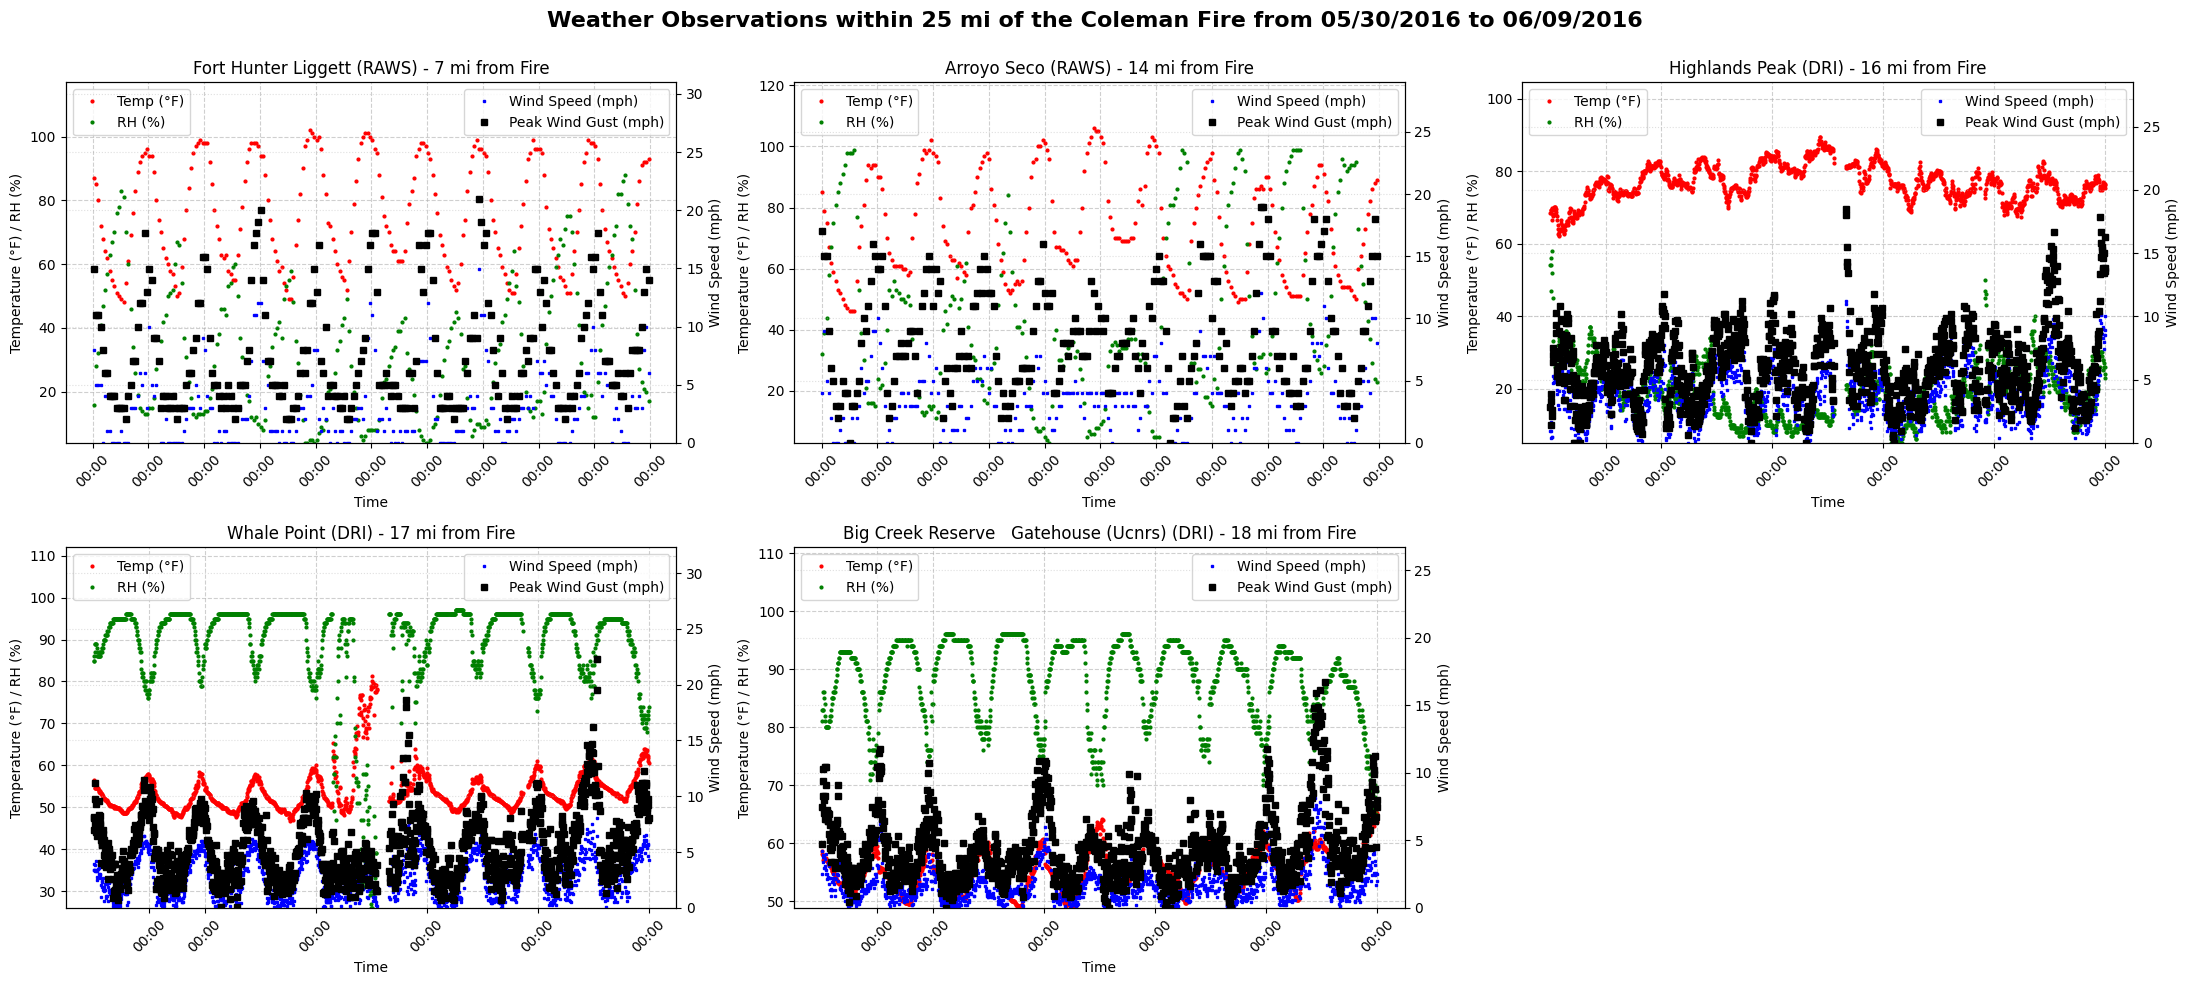

In [ ]:
 #@title Plot the Data with Symbols
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

# Define time column (swap between 'DateTime' and 'local_time' as needed)
time_column = 'local_time'  # Change this to 'DateTime' if needed

# Select relevant columns
selected_columns = [time_column, 'tempf', 'rh', 'wind_speed_mph', 'peak_wind_gust_mph',
                    'stid', 'name', 'network', 'distance_to_fire_miles', 'IncidentName']
subset_data = fire_obs[selected_columns].copy()

# Convert time column to datetime objects if they aren't already
subset_data[time_column] = pd.to_datetime(subset_data[time_column])

# Get Incident Name for main title
incident_name = subset_data['IncidentName'].iloc[0]  # Assuming all rows have the same incident name

# Get unique stations sorted by distance (closest to farthest)
stations = subset_data.groupby('name')['distance_to_fire_miles'].min().sort_values().index.tolist()

# Define subplot layout
num_stations = len(stations)
cols = 3  # 3 subplots per row
rows = -(-num_stations // cols)  # Ceiling division to determine rows

# Create figure and axes
fig, axes = plt.subplots(rows, cols, figsize=(22, 5 * rows))

# Flatten axes for easier indexing (handle cases with extra empty subplots)
axes = axes.flatten()

# Plot data for each station
for i, station in enumerate(stations):
    ax = axes[i]
    station_data = subset_data[subset_data['name'] == station]

    # Left Y-Axis (Temperature & RH) with Symbols
    ax.plot(station_data[time_column], station_data['tempf'], 'o', label='Temp (°F)', color='red', markersize=2)  # Red circles for temperature
    ax.plot(station_data[time_column], station_data['rh'], 'o', label='RH (%)', color='green', markersize=2)  # Green circles for RH

    ax.set_ylabel('Temperature (°F) / RH (%)')
    ax.set_ylim([station_data[['tempf', 'rh']].min().min(), station_data[['tempf', 'rh']].max().max()+15])
    ax.grid(True, linestyle='--', alpha=0.6)  # Add gridlines

    # Create a second Y-axis for Wind Speed with Symbols
    ax2 = ax.twinx()
    ax2.plot(station_data[time_column], station_data['wind_speed_mph'], 's', label='Wind Speed (mph)', color='blue', markersize=2)  # Blue squares for wind speed
    ax2.plot(station_data[time_column], station_data['peak_wind_gust_mph'], 's', label='Peak Wind Gust (mph)', color='black', markersize=4)  # black squares for wind gusts

    ax2.set_ylabel('Wind Speed (mph)')
    ax2.set_ylim([station_data[['wind_speed_mph', 'peak_wind_gust_mph']].min().min(), station_data[['wind_speed_mph', 'peak_wind_gust_mph']].max().max()+10])
    ax2.grid(True, linestyle=':', alpha=0.4)  # Lighter grid for secondary axis

    # Extract network name and distance to fire (rounded)
    network_name = station_data['network'].iloc[0]
    distance_to_fire = round(station_data['distance_to_fire_miles'].iloc[0])  # Round to nearest mile

    # Set subplot title with station name, network, and distance to fire
    ax.set_title(f"{station} ({network_name}) - {distance_to_fire} mi from Fire")

    # Format X-Axis to show time
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Time format (HH:MM)
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # Auto spacing based on range
    ax.tick_params(axis='x', rotation=45)  # Rotate labels for clarity

    # Ensure each subplot has its own time labels
    ax.set_xlabel('Time')

    # Add legends
    ax.legend(loc='upper left', fontsize=10)
    ax2.legend(loc='upper right', fontsize=10)

# Remove any empty subplots if num_stations is not a multiple of cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Add main title for the entire figure
start_date_str = (ignition_date - timedelta(days=start_buffer_days)).strftime('%m/%d/%Y')
end_date_str = (ignition_date + timedelta(days=end_buffer_days)).strftime('%m/%d/%Y')
fig.suptitle(f"Weather Observations within {radius_miles} mi of the {incident_name} Fire from {start_date_str} to {end_date_str}"
             ,fontsize=16, fontweight='bold')

# Adjust layout for clarity
plt.tight_layout(rect=[0, 0, 1, 0.98])  # Leave space for suptitle

plt.savefig(f'/content/drive/MyDrive/fire/OutputFiles/img/{incident_name}_weather_observations.png')
plt.show()

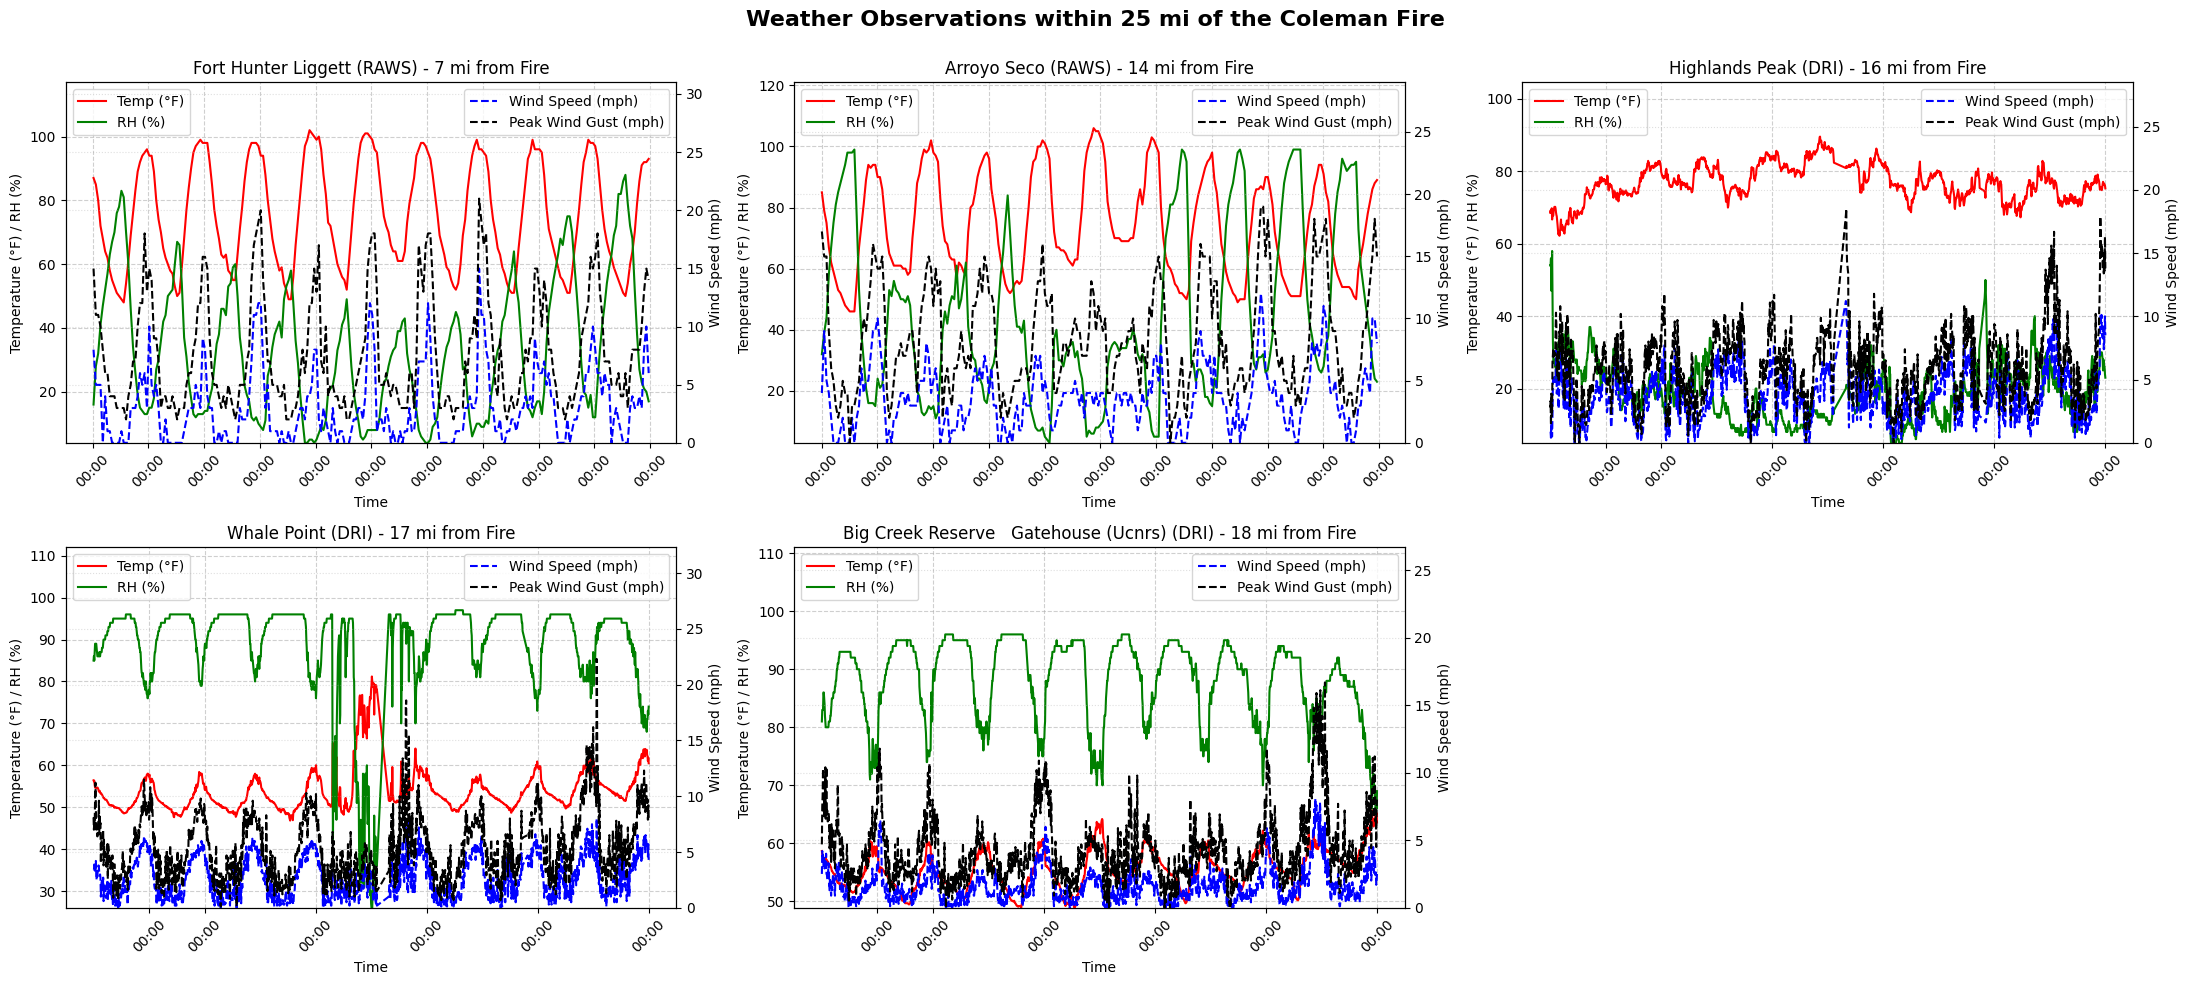

In [ ]:
#@title Plot the Data
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

# Define time column (swap between 'DateTime' and 'local_time' as needed)
time_column = 'local_time'  # Change this to 'DateTime' if needed

# Select relevant columns
selected_columns = [time_column, 'tempf', 'rh', 'wind_speed_mph', 'peak_wind_gust_mph',
                    'stid', 'name', 'network', 'distance_to_fire_miles', 'IncidentName']
subset_data = fire_obs[selected_columns].copy()

# Convert time column to datetime objects if they aren't already
subset_data[time_column] = pd.to_datetime(subset_data[time_column])

# Get Incident Name for main title
incident_name = subset_data['IncidentName'].iloc[0]  # Assuming all rows have the same incident name

# Get unique stations sorted by distance (closest to farthest)
stations = subset_data.groupby('name')['distance_to_fire_miles'].min().sort_values().index.tolist()

# Define subplot layout
num_stations = len(stations)
cols = 3  # 3 subplots per row
rows = -(-num_stations // cols)  # Ceiling division to determine rows

# Create figure and axes
fig, axes = plt.subplots(rows, cols, figsize=(22, 5 * rows))

# Flatten axes for easier indexing (handle cases with extra empty subplots)
axes = axes.flatten()

# Plot data for each station
for i, station in enumerate(stations):
    ax = axes[i]
    station_data = subset_data[subset_data['name'] == station]

    # Left Y-Axis (Temperature & RH)
    ax.plot(station_data[time_column], station_data['tempf'], label='Temp (°F)', color='red')
    ax.plot(station_data[time_column], station_data['rh'], label='RH (%)', color='green')

    ax.set_ylabel('Temperature (°F) / RH (%)')
    ax.set_ylim([station_data[['tempf', 'rh']].min().min(), station_data[['tempf', 'rh']].max().max()+15])
    ax.grid(True, linestyle='--', alpha=0.6)  # Add gridlines

    # Create a second Y-axis for Wind Speed
    ax2 = ax.twinx()
    ax2.plot(station_data[time_column], station_data['wind_speed_mph'], '--', label='Wind Speed (mph)', color='blue')
    ax2.plot(station_data[time_column], station_data['peak_wind_gust_mph'], '--', label='Peak Wind Gust (mph)', color='black')

    ax2.set_ylabel('Wind Speed (mph)')
    ax2.set_ylim([station_data[['wind_speed_mph', 'peak_wind_gust_mph']].min().min(), station_data[['wind_speed_mph', 'peak_wind_gust_mph']].max().max()+10])
    ax2.grid(True, linestyle=':', alpha=0.4)  # Lighter grid for secondary axis

    # Extract network name and distance to fire (rounded)
    network_name = station_data['network'].iloc[0]
    distance_to_fire = round(station_data['distance_to_fire_miles'].iloc[0])  # Round to nearest mile

    # Set subplot title with station name, network, and distance to fire
    ax.set_title(f"{station} ({network_name}) - {distance_to_fire} mi from Fire")

    # Format X-Axis to show time
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Time format (HH:MM)
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # Auto spacing based on range
    ax.tick_params(axis='x', rotation=45)  # Rotate labels for clarity

    # Ensure each subplot has its own time labels
    ax.set_xlabel('Time')

    # Add legends
    ax.legend(loc='upper left', fontsize=10)
    ax2.legend(loc='upper right', fontsize=10)

# Remove any empty subplots if num_stations is not a multiple of cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Add main title for the entire figure
fig.suptitle(f"Weather Observations within {radius_miles} mi of the {incident_name} Fire", fontsize=16, fontweight='bold')

# Adjust layout for clarity
plt.tight_layout(rect=[0, 0, 1, 0.98])  # Leave space for suptitle
plt.show()


In [ ]:
#input_fire_df.columns
for i in range(0, len(input_fire_df)):
  print([i, input_fire_df[['IncidentName', 'IncidentSize']].iloc[i]])

[0, IncidentName     15-10
IncidentSize    5000.0
Name: 0, dtype: object]
[1, IncidentName    15-14
IncidentSize    712.0
Name: 1, dtype: object]
[2, IncidentName      15-4
IncidentSize    2659.0
Name: 2, dtype: object]
[3, IncidentName    3-13 WADDELL
IncidentSize           500.0
Name: 3, dtype: object]
[4, IncidentName       4-1
IncidentSize    1000.0
Name: 4, dtype: object]
[5, IncidentName       4-4
IncidentSize    1000.0
Name: 5, dtype: object]
[6, IncidentName    AIRLINE
IncidentSize     1314.0
Name: 6, dtype: object]
[7, IncidentName    AMERICAN
IncidentSize       532.0
Name: 8, dtype: object]
[8, IncidentName      ATLAS
IncidentSize    25000.0
Name: 9, dtype: object]
[9, IncidentName     BEAR
IncidentSize    391.0
Name: 10, dtype: object]
[10, IncidentName     BUTTS
IncidentSize    4300.0
Name: 11, dtype: object]
[11, IncidentName    CARMEL.
IncidentSize     6905.0
Name: 13, dtype: object]
[12, IncidentName    CENTRAL LNU COMPLEX
IncidentSize               110720.0
Name: 14, dt

In [ ]:
#@title Plot the station location for the entire network

import matplotlib.pyplot as plt
import geopandas as gpd
import requests
import zipfile
import io
import pandas as pd
from shapely.geometry import Point
from matplotlib.lines import Line2D  # Import Line2D for custom legend

# --- Fetch station data ---
# Sample Data (Replace with your actual values)
api_token = 'd8c6aee36a994f90857925cea26934be'
cwa = 'MTR'  # Example CWA
networks_string = '1,2,96, 121, 122, 229, 278, 286'  # Example network string

# --- Helper function to fetch data ---
def fetch_station_data(cwa, networks_string, api_token):
    # --- Fetch Network Data ---
    #Network list
    network_list = [networks_string]

    #1 = ASOS/AWOS
    #2 = RAWS
    #229 = PGE

    networks_string = ','.join(network_list)


    # Define the API endpoint for networks
    networks_url = "https://api.synopticdata.com/v2/networks"

    # Parameters for the API request
    network_params = {
        'token': api_token,
        'output': 'json'
    }

    # Make the API request
    network_response = requests.get(networks_url, params=network_params)

    # Initialize network_dict
    network_dict = {}

    # Check if the request was successful
    if network_response.status_code == 200:
        # Parse the JSON response
        network_data = network_response.json()

        # Extract network information
        networks = network_data.get('MNET', [])

        # Create a dictionary to store network IDs and SHORTNAMEs
        network_dict = {network['ID']: network.get('SHORTNAME', 'Unknown') for network in networks}


    # --- End Fetch Network Data ---

    # Define the URL and parameters from the Synoptic API for station metadata
    metadata_url = "https://api.synopticdata.com/v2/stations/metadata"

    metadata_params = {
        'token': api_token,
        'cwa': f'{cwa}',
        'network': networks_string,
        'output': 'json'
    }

    # Make the API request for station metadata
    print(f"Metadata API Request URL: {metadata_url}?{'&'.join([f'{key}={value}' for key, value in metadata_params.items()])}")
    metadata_response = requests.get(metadata_url, params=metadata_params)

    # Check if the metadata request was successful
    if metadata_response.status_code == 200:
        metadata = metadata_response.json()
        stations = metadata.get('STATION', [])

        if not stations:
            print("No stations found for the given parameters and networks in the metadata. Please check parameters and network list.")
            print(f"Parameters used: {metadata_params}")
            return None  # Return None if no stations are found
        else:
            print(f"Found {len(stations)} stations for the given parameters and networks in the metadata")
            # Prepare to store dataframes for each station
            stations_data = []
            for station in stations:
                stid = station.get('STID')
                name = station.get('NAME')
                latitude = station.get('LATITUDE')
                longitude = station.get('LONGITUDE')
                elevation = station.get('ELEVATION')
                if 'MNET_ID' in station:
                    network_id = str(station.get('MNET_ID'))
                else:
                    network_id = None

                stations_data.append({
                    'STID': stid,
                    'name': name,
                    'latitude': latitude,
                    'longitude': longitude,
                    'elevation': elevation,
                    'network_id': network_id
                })

            stations_df = pd.DataFrame(stations_data)
            # Convert latitude and longitude to numeric (float)
            stations_df['latitude'] = pd.to_numeric(stations_df['latitude'], errors='coerce')
            stations_df['longitude'] = pd.to_numeric(stations_df['longitude'], errors='coerce')


             # Map network ID to network name
            stations_df['network'] = stations_df['network_id'].map(network_dict).fillna('Unknown Network')

            return stations_df  # Return the DataFrame
    else:
        print(f"Failed to retrieve station metadata. Status code: {metadata_response.status_code}")
        if metadata_response.status_code != 200:
            try:
                print(f"Error Message from API: {metadata_response.json().get('RESPONSE_MESSAGE')}")
            except:
                print("Could not decode JSON error message from API")
        return None  # Return None if request fails

stations_df = fetch_station_data(cwa, networks_string, api_token)
# --- End fetch station data ---


# URL of the ZIP file containing the shapefile
url = "https://www.weather.gov/source/gis/Shapefiles/County/c_19se23.zip"



# Download the ZIP file
response = requests.get(url)

# Extract the contents of the ZIP file
with zipfile.ZipFile(io.BytesIO(response.content), 'r') as zip_ref:
    zip_ref.extractall("temp_folder")  # Extract to a temporary folder

# Read the shapefile using GeoPandas
map_df = gpd.read_file("temp_folder/c_19se23.shp")
#tmp_df = gpd.read_file("temp_folder/c_19se23.shp")

# Now you have the GeoDataFrame ready to use
print("NWS GIS data (CWA) loaded successfully.")


print("Read in NWS GIS data (Zone Information)")
zone_map_df = gpd.read_file("https://www.weather.gov/source/gis/Shapefiles/WSOM/z_08mr23.zip")
tmp_map_df = zone_map_df.query("CWA==(@cwa)")
output_crs = 'epsg:4326'
zone_map_df = tmp_map_df.to_crs(output_crs)
region_df = map_df.copy()

cwa_bound = zone_map_df.dissolve()

# Filter region_df to include specific states
region_df = region_df[region_df['STATE'].isin(['CA', 'AZ', 'NV', 'OR'])]


# Check if the specified CWA abbreviation exists in the DataFrame
if cwa not in map_df['CWA'].unique():
    print("CWA not found---check your abbreviation")
    sys.exit()  # Exit the program cleanly if CWA is not found


map_df = map_df[map_df['CWA'].str.contains(cwa)]


# Create a figure and an axes object
plt.clf()
fig, ax = plt.subplots(figsize=(20, 20))  # Adjust figsize as needed

# Plot cwa_bound first (as the base layer)
cwa_bound.plot(ax=ax, color='lightgray', edgecolor='black')  # Customize color and edgecolor

zone_map_df.boundary.plot(ax=ax, color='blue', markersize=10)  # Customize color and markersize
region_df.plot(ax=ax, color='gray', edgecolor='black', label='County Boundaries')


# --- Plot station locations ---
if stations_df is not None:
    # Calculate network counts
    network_counts = stations_df['network'].value_counts()
    # Define a color mapping for network types
    network_colors = {
        'ASOS/AWOS': 'red',
        'RAWS': 'green',
        'PGE': 'white',
        'MARITIME': 'purple',
        'NDBC':'purple',
        'NTC': 'purple',
        'NOS-PORTS': 'purple',
        'NOS-NWLON': 'purple',
        'Unknown Network': 'black'
    }

    # Create a scatter plot for each station, using network colors
    for index, row in stations_df.iterrows():
        ax.scatter(row['longitude'], row['latitude'], color=network_colors.get(row['network'], 'black'), s=25, label=row['network'])  # Plot the station point with appropriate color

  # Create custom legend
    legend_elements = []
    for net, color in network_colors.items():
      count = network_counts.get(net, 0) # Get count for network, default to 0 if not found
      legend_label = f'{net} ({count})'  # Create label: "Network Name (Count)"
      legend_elements.append(Line2D([0], [0], marker='o', color='w', label=legend_label, markerfacecolor=color, markersize=14))

    # Add the custom legend to the plot
    ax.legend(handles=legend_elements, loc='upper right', title='Network Type')
else:
    print("No station data to plot.")

# --- End plot station locations ---

# Set title and labels (optional)
ax.set_title(f'Observation Sites across NWS {cwa} County Warning Area')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')


# Calculate buffer amount (adjust as needed)
buffer_amount = 0.1  # Example: 0.1 degrees

# Set the plot extent with buffer and also generate gridlines
ax.set_xlim(cwa_bound.total_bounds[0] - buffer_amount, cwa_bound.total_bounds[2] + buffer_amount)
ax.set_ylim(cwa_bound.total_bounds[1] - buffer_amount, cwa_bound.total_bounds[3] + buffer_amount)

ax.grid(True, linestyle='dashed', which='both', linewidth=0.5, color='black')


# Turn off latitude and longitude ticks and labels
#Remove the labels of latitude and longitude, but retain gridlines
ax.set_xticklabels([])
ax.set_yticklabels([])

#Latitude and Longitude Label
ax.set_xlabel('')
ax.set_ylabel('')


# Display the plot
plt.show()

In [ ]:
(stations_df.query("network in ['MARITIME', 'NDBC', 'NTC', 'NOS-PORTS']"))